# **Dominance or Decline  --**
## **Decoding New York Red Bulls' 2024 Performance**  

---

&nbsp;

# 📊 **Project Overview**  
The **New York Red Bulls (RBNY)**, one of the **ten charter clubs** of Major League Soccer (MLS), have been competing since the league’s founding in 1996.  This project analyzes their performance trends over the years to uncover strengths, weaknesses, and opportunities for improvement.  

Using **statistical analysis and visualizations**, we will:  
- ✅ Identify long-term performance trends  
- ✅ Compare key seasons (**2024 vs. 2021**)  
- ✅ Evaluate the impact of different player roles  
- ✅ Provide actionable insights for future success  

---

# 📌 **Sections Breakdown**  

### 📈 **Performance Trends Over the Years**  
- Analyzes **goals per game** across different seasons using a **dot plot**.  
- Identifies whether the team is improving or stagnating over time.  

### ⚔️ **Comparing Strong vs. Weak Seasons (2024 vs. 2021)**  
- Compares **2024** (a strong season) to **2021** (a weaker season).  
- **Heat maps** visualize key factors driving success and areas for improvement.  
- Focus on **attackers, defenders, and midfielders** to pinpoint impactful attributes.  

### 🎯 **Role-Specific Impact Analysis**  
- Examines the **contributions of attackers, defenders, and midfielders** to team performance.  
- Identifies **top-performing players** and those needing improvement based on key metrics.  

### 📢 **Final Report & Insights**  
- Summarizes key findings with **data-driven insights**.  
- Provides **strategic recommendations** for maintaining success and enhancing weaker areas.  


---

&nbsp;


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

##### Load all data

In [3]:
all_data = {}

for year in range(2010, 2025):
    file_path = f"RBNY_yearly_stats/main_stats/all_{year}_stats.xlsx"
    sheets = pd.ExcelFile(file_path).sheet_names  # Get all sheet names
    
    # Load sheets with different skiprows based on sheet name
    dataframes = {
        f"{sheet}_{year}": pd.read_excel(file_path, sheet_name=sheet, skiprows=1 if sheet.lower() == "score" else 2)
        for sheet in sheets
    }
    
    all_data.update(dataframes)  # Store in the main dictionary    

##### Exclude players with less than 90 mins playtime

In [4]:
# Loop through all sheets and filter out players with "90s" < 1.0 aka outliers
for sheet_name, df in all_data.items():
    if "90s" in df.columns:
        filtered_df = df[(df["90s"] >= 1.0) & (df["90s"].notnull())].copy()  # Keep only non-null players who played at least 90 minutes
        all_data[sheet_name] = filtered_df
        print(f"✅ Filtered {sheet_name}: {len(df) - len(filtered_df)} rows removed.")
    else:
        all_data[sheet_name] = df  # If "90s" column is missing, keep the original
    

✅ Filtered standard_stats_2010: 3 rows removed.
✅ Filtered goalkeeping_2010: 0 rows removed.
✅ Filtered shooting_2010: 3 rows removed.
✅ Filtered playing_time_2010: 3 rows removed.
✅ Filtered miscellaneous_2010: 3 rows removed.
✅ Filtered standard_stats_2011: 6 rows removed.
✅ Filtered goalkeeping_2011: 0 rows removed.
✅ Filtered shooting_2011: 6 rows removed.
✅ Filtered playing_time_2011: 6 rows removed.
✅ Filtered miscellaneous_2011: 6 rows removed.
✅ Filtered standard_stats_2012: 2 rows removed.
✅ Filtered goalkeeping_2012: 0 rows removed.
✅ Filtered shooting_2012: 2 rows removed.
✅ Filtered playing_time_2012: 2 rows removed.
✅ Filtered miscellaneous_2012: 2 rows removed.
✅ Filtered standard_stats_2013: 4 rows removed.
✅ Filtered goalkeeping_2013: 0 rows removed.
✅ Filtered shooting_2013: 4 rows removed.
✅ Filtered playing_time_2013: 4 rows removed.
✅ Filtered miscellaneous_2013: 4 rows removed.
✅ Filtered standard_stats_2014: 8 rows removed.
✅ Filtered goalkeeping_2014: 0 rows remo

## 📈 **Performance Trends Over the Years** 


Question: Is the performance of RBNY team improving over the years?



Analysis: 

In [5]:
# After your existing code:

# Initialize dictionaries to store the total values for Gls.1 and A.1
gls_1_totals = {}
a_1_totals = {}

# Iterate over the years to process "standard_stats_*" sheet for each year
for year in range(2010, 2025):
    standard_stats_sheet = f"standard_stats_{year}"  # standard_stats_* sheet for Gls.1 and A.1
    
    if standard_stats_sheet in all_data:  # Ensure the standard_stats_* sheet exists
        df = all_data[standard_stats_sheet]
        print(f"\nColumns in {standard_stats_sheet}:", df.columns)  # Debugging check
        
        # Extract Gls.1 and A.1
        if "Gls.1" in df.columns and "Ast.1" in df.columns:  # Check for the existence of both columns
            df["Gls.1"] = pd.to_numeric(df["Gls.1"], errors="coerce")  # Convert to numeric
            df["Ast.1"] = pd.to_numeric(df["Ast.1"], errors="coerce")  # Convert to numeric
            
            # Sum the values for Gls.1 and A.1 for the year
            gls_1_totals[year] = df["Gls.1"].sum() if not df["Gls.1"].isnull().all() else 0
            a_1_totals[year] = df["Ast.1"].sum() if not df["Ast.1"].isnull().all() else 0
        else:
            gls_1_totals[year] = 0
            a_1_totals[year] = 0

# Create a DataFrame to store the yearly totals for Gls.1 and A.1
df_gls_a1_totals = pd.DataFrame({
    "Year": list(gls_1_totals.keys()),
    "Gls.1 Total": list(gls_1_totals.values()),
    "Ast.1 Total": list(a_1_totals.values())
})

# Perform outlier detection using IQR (Interquartile Range) and exclude outliers
def remove_outliers(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data to exclude outliers
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_filtered

# Remove outliers for Gls.1 Total and Ast.1 Total
df_gls_a1_totals_filtered_gls_1 = remove_outliers(df_gls_a1_totals, "Gls.1 Total")
df_gls_a1_totals_filtered_a_1 = remove_outliers(df_gls_a1_totals, "Ast.1 Total")

# Recalculate the averages after outlier removal
average_gls_1_filtered = df_gls_a1_totals_filtered_gls_1["Gls.1 Total"].mean()
average_a_1_filtered = df_gls_a1_totals_filtered_a_1["Ast.1 Total"].mean()

# Print the totals for each year and the averages after removing outliers
print("\nYearly Totals for Gls.1 and Ast.1 (Outliers Removed):")
print(df_gls_a1_totals_filtered_gls_1)

print(f"\nAverage Gls.1 over the years (2010-2024) after removing outliers: {average_gls_1_filtered:.2f}")
print(f"Average Ast.1 over the years (2010-2024) after removing outliers: {average_a_1_filtered:.2f}")



Columns in standard_stats_2010: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2011: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2012: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2013: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK'

In [6]:
# Merge the filtered data into one DataFrame
df_final = df_gls_a1_totals_filtered_gls_1[["Year", "Gls.1 Total"]].merge(
    df_gls_a1_totals_filtered_a_1[["Year", "Ast.1 Total"]], on="Year"
)

# Rename columns for clarity
df_final.rename(columns={"Gls.1 Total": "Goals_per_90", "Ast.1 Total": "Assists_per_90"}, inplace=True)

# Calculate the total Goals + Assists per 90
df_final["G+A_per_90"] = df_final["Goals_per_90"] + df_final["Assists_per_90"]

# Save the data as a CSV for Tableau
df_final.to_csv("RBNY_yearly_stats/tableau_data/goals_assists_per_year.csv", index=False)


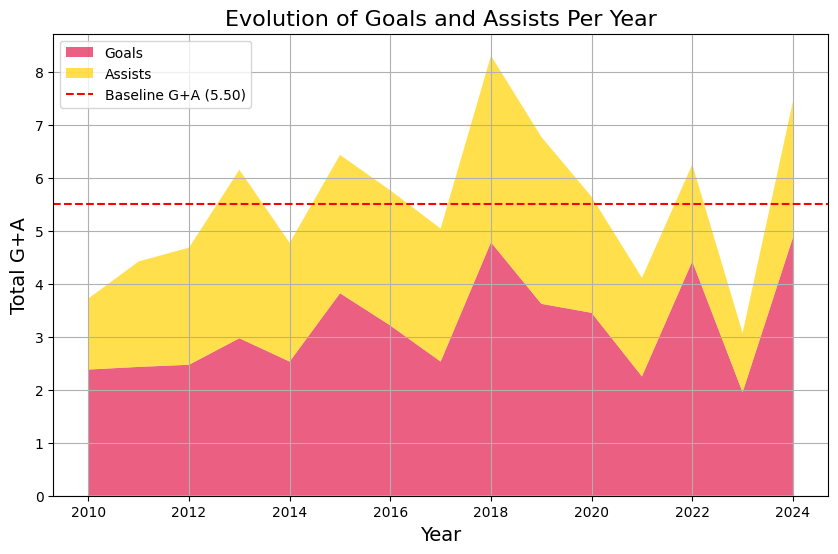

In [34]:
# Calculate the average of total goals and assists (already calculated)
average_total = (average_gls_1_filtered + average_a_1_filtered)

# Plotting the stacked area chart
plt.figure(figsize=(10, 6))

# Define custom colors for the stackplot
colors = ["#e21b4d", "#ffd300"] 

plt.stackplot(df_gls_a1_totals["Year"], df_gls_a1_totals["Gls.1 Total"], df_gls_a1_totals["Ast.1 Total"], 
             labels=["Goals", "Assists"], alpha=0.7, colors=colors)

# Adding the average line
plt.axhline(average_total, color='red', linestyle='--', label=f"Baseline G+A ({average_total:.2f})")

plt.title("Evolution of Goals and Assists Per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total G+A", fontsize=14)
plt.legend(loc="upper left")

plt.grid(True)
plt.show()



Graph 1 illustrates an area graph, where the blue section represents Goals/90 (goals per 90 minutes) and the orange section represents Assists/90 (assists per 90 minutes). The cumulative value for each year is indicated by the highest point on the graph, which shows the combined total of goals and assists per 90 minutes.

Years with a cumulative total above 5.50 outperform the average, including 2024, 2022, 2018, 2015, and 2013. Conversely, years falling below this threshold reflect underperformance.

It is important to note that Goals/90 and Assists/90 were used to account for the varying playing time across seasons. This normalization ensures a fair comparison, as years with less playing time naturally have fewer opportunities for scoring or assisting.

##### Calculating team performance across years


Columns in standard_stats_2010: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2011: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2012: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'Matches'],
      dtype='object')

Columns in standard_stats_2013: Index(['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls',
       'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK'

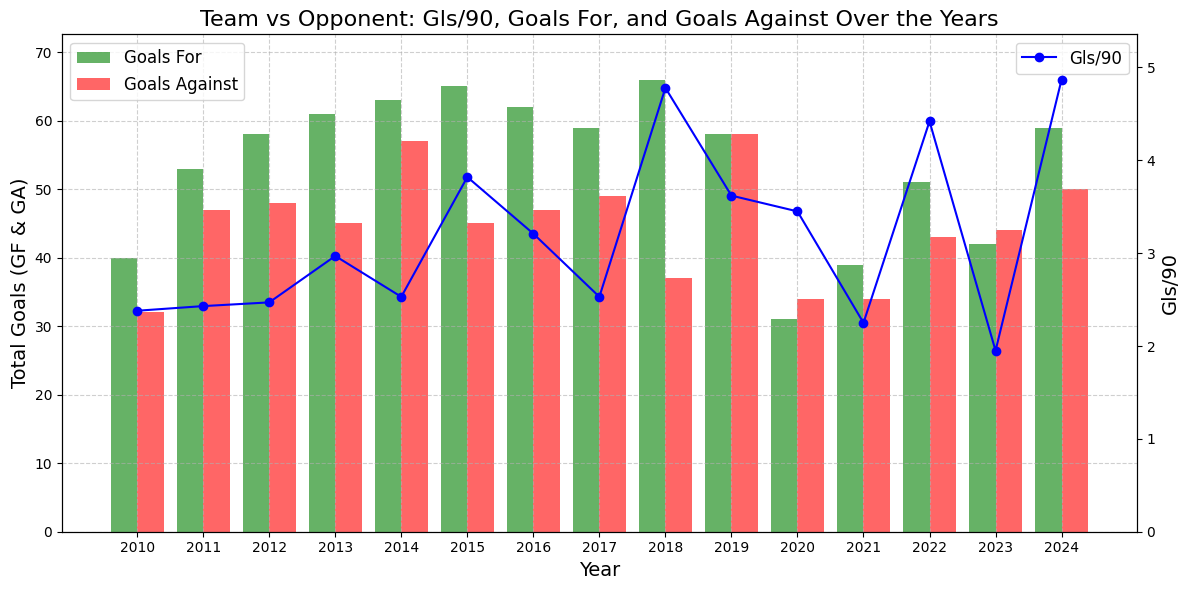

In [8]:
# Updated dictionaries for data
goals_for_data = {}  # GF for the team
goals_against_data = {}  # GA for the team
gls_1_data = {}  # Gls.1 for the team

# Iterate over the years to calculate the sum of G+A (goals plus assist), GF, and GA for the team
for year in range(2010, 2025):
    standard_stats_sheet = f"standard_stats_{year}"  # standard_stats_* sheet for G+A
    score_sheet = f"score_{year}"  # score_* sheet for GF and GA
    
    if standard_stats_sheet in all_data:  # Ensure the standard_stats_* sheet exists
        df = all_data[standard_stats_sheet]
        print(f"\nColumns in {standard_stats_sheet}:", df.columns)  # Debugging check
        
        # Extract Gls.1 (Fixed issue)
        if "Gls.1" in df.columns:  # **Corrected column check**
            df["Gls.1"] = pd.to_numeric(df["Gls.1"], errors="coerce")  # Convert to numeric
            gls_1_data[year] = df["Gls.1"].sum() if not df["Gls.1"].isnull().all() else 0  
        else:
            gls_1_data[year] = 0
    
    if score_sheet in all_data:  # Ensure the score_* sheet exists
        df = all_data[score_sheet]

        # Ensure the GF and GA columns exist in the score sheet
        if "GF" in df.columns and "GA" in df.columns:
            df["GF"] = pd.to_numeric(df["GF"], errors="coerce")  # Convert to numeric
            df["GA"] = pd.to_numeric(df["GA"], errors="coerce")
            goals_for_data[year] = df["GF"].sum()  # Sum GF for the year
            goals_against_data[year] = df["GA"].sum()  # Sum GA for the year
        else:
            goals_for_data[year] = None
            goals_against_data[year] = None


# Convert to DataFrame for plotting
df_plot = pd.DataFrame({
    "Year": list(goals_for_data.keys()),
    "Gls/90": list(gls_1_data.values()),
    "Goals For": list(goals_for_data.values()),
    "Goals Against": list(goals_against_data.values())
})

# Print to check if data is correctly prepared for plotting
print("\nData for plotting:")
print(df_plot)

# Check if any G+A, GF, or GA values are None or NaN
if df_plot["Gls/90"].isnull().all() or df_plot["Goals For"].isnull().all() or df_plot["Goals Against"].isnull().all():
    print("No valid data to plot!")

# Set the width for bar plots
width = 0.4

# Create figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Goals For and Goals Against as bar graphs on ax1
ax1.bar(df_plot["Year"] - width/2, df_plot["Goals For"], width=width, color='green', alpha=0.6, label="Goals For")
ax1.bar(df_plot["Year"] + width/2, df_plot["Goals Against"], width=width, color='red', alpha=0.6, label="Goals Against")

# Create secondary axis for Gls/90 line plot (independent y-axis)
ax2 = ax1.twinx()

# Plot Gls/90 as a line graph with dots on ax2
ax2.plot(df_plot["Year"], df_plot["Gls/90"], marker='o', linestyle='-', color='blue', label="Gls/90")

# **Handle NaN values before finding y-axis limits**
df_plot = df_plot.fillna(0)  # Replace NaN with 0 to prevent errors

# Find y-axis limits for Goals For & Goals Against (ax1)
y_min1 = df_plot[["Goals For", "Goals Against"]].min().min()
y_max1 = df_plot[["Goals For", "Goals Against"]].max().max()
y_max1 += y_max1 * 0.1  # Adding 10% buffer

# Find y-axis limits for Gls/90 (ax2) and apply a buffer (e.g., 10%)
y_min2 = df_plot["Gls/90"].min()
y_max2 = df_plot["Gls/90"].max()
y_max2 += y_max2 * 0.1  # Adding 10% buffer for Gls/90

# Set y_min to 0 for both axes
y_min = 0

# Apply the y-axis limits to both axes
ax1.set_ylim(y_min, y_max1)
ax2.set_ylim(y_min, y_max2)

# Set labels and title
ax1.set_ylabel("Total Goals (GF & GA)", fontsize=14)
ax2.set_ylabel("Gls/90", fontsize=14)
ax1.set_xlabel("Year", fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

# Title and legends
plt.title("Team vs Opponent: Gls/90, Goals For, and Goals Against Over the Years", fontsize=16)
plt.xticks(df_plot["Year"])
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

# Tight layout for better spacing
plt.tight_layout()
plt.show()



In [9]:
# Calculate Goal Difference for each year
df_plot["Goal Difference"] = df_plot["Goals For"] - df_plot["Goals Against"]

# Compute the average goal difference
average_goal_difference = df_plot["Goal Difference"].mean()

# Print the result
# Print the Goal Difference for each year
for year, goal_diff in zip(df_plot["Year"], df_plot["Goal Difference"]):
    print(f"In {year}, the goal difference was of {goal_diff:.2f}")
print(f"\nAverage Goal Difference (2010-2024): {average_goal_difference:.2f}")

In 2010, the goal difference was of 8.00
In 2011, the goal difference was of 6.00
In 2012, the goal difference was of 10.00
In 2013, the goal difference was of 16.00
In 2014, the goal difference was of 6.00
In 2015, the goal difference was of 20.00
In 2016, the goal difference was of 15.00
In 2017, the goal difference was of 10.00
In 2018, the goal difference was of 29.00
In 2019, the goal difference was of 0.00
In 2020, the goal difference was of -3.00
In 2021, the goal difference was of 5.00
In 2022, the goal difference was of 8.00
In 2023, the goal difference was of -2.00
In 2024, the goal difference was of 9.00

Average Goal Difference (2010-2024): 9.13


Use the same data but divided the amount of 90 minutes. certain years have played less games like 2020 and 2021 with covid.

## ⚔️ **Comparing Strong vs. Weak Seasons (2024 vs. 2021)**  

Direct comparison of 2021 and 2024 metrics using statistical tests to determine whether a statistical difference exists.
- H0: There is no significant difference between a specific metric in 2021 and 2024
- H1: A significant difference exists between a specific metric in 2021 and 2024 

&nbsp;

Note
- Goalkeepers were excluded from the statistical analysis due to having only two samples per year. Statistical tests require a minimum of 3–5 samples for meaningful results.

&nbsp;

##### Preparing the data for statistical testing

In [10]:
# Print all DataFrame names available from all_data
print("Loaded DataFrames:")
for df_name in all_data.keys():
    print(df_name)

Loaded DataFrames:
standard_stats_2010
score_2010
goalkeeping_2010
shooting_2010
playing_time_2010
miscellaneous_2010
standard_stats_2011
score_2011
goalkeeping_2011
shooting_2011
playing_time_2011
miscellaneous_2011
standard_stats_2012
score_2012
goalkeeping_2012
shooting_2012
playing_time_2012
miscellaneous_2012
standard_stats_2013
score_2013
goalkeeping_2013
shooting_2013
playing_time_2013
miscellaneous_2013
standard_stats_2014
score_2014
goalkeeping_2014
shooting_2014
playing_time_2014
miscellaneous_2014
standard_stats_2015
score_2015
goalkeeping_2015
shooting_2015
playing_time_2015
miscellaneous_2015
standard_stats_2016
score_2016
goalkeeping_2016
shooting_2016
playing_time_2016
miscellaneous_2016
standard_stats_2017
score_2017
goalkeeping_2017
shooting_2017
playing_time_2017
miscenallenous_2017
standard_stats_2018
score_2018
goalkeeping_2018
advanced_goalkeeping_2018
shooting_2018
passing_2018
pass_types_2018
shot_creation_2018
defensive_action_2018
possession_2018
playing_time_2

In [11]:
# display all columns
pd.set_option('display.max_columns', None)

##### Compiling repeating columns that must be eliminated

In [12]:
# Set the years to be compared
compared_year = 2021
interesting_year = 2024

# Identify the general stats columns (from the first sheet)
general_stats_2018_cols = set(all_data.get(f"standard_stats_{compared_year}", pd.DataFrame()).columns)
general_stats_2024_cols = set(all_data.get(f"standard_stats_{interesting_year}", pd.DataFrame()).columns)

# Drop position, player name and amount of 90 minutes played to avoid deleting them from any sheets in later steps
general_stats_2018_cols = [col for col in general_stats_2018_cols if col not in {"Pos", "Player", "90s"}]
general_stats_2024_cols = [col for col in general_stats_2024_cols if col not in {"Pos", "Player", "90s"}]

print(general_stats_2018_cols)

['PrgC', 'xG.1', 'Min', 'Gls.1', 'G+A-PK', 'CrdR', 'Gls', 'G+A.1', 'Nation', 'npxG+xAG', 'G-PK', 'PrgP', 'Age', 'Ast.1', 'xAG.1', 'CrdY', 'npxG', 'Starts', 'xAG', 'PrgR', 'PKatt', 'xG', 'PK', 'npxG.1', 'G+A', 'xG+xAG', 'npxG+xAG.1', 'G-PK.1', 'Ast', 'Matches', 'MP']


##### Filtering sheets of interest & removing duplicate columns

In [13]:
# Create a new dictionary for non-repeating columns
filtered_data = {}

for df_name, df in all_data.items():
    # Only keep data from 2021 and 2024
    if str(compared_year) not in df_name and str(interesting_year) not in df_name:
        continue  # Skip any other years

    # Always keep the general stats sheets for these years WITHOUT filtering columns
    if "standard_stats" in df_name:  # Match any standard stats sheet
        filtered_data[df_name] = df  # Store the full DataFrame
        continue  # Skip column filtering

    # Identify non-repeating columns for all other sheets
    reference_cols = general_stats_2018_cols if str(compared_year) in df_name else general_stats_2024_cols
    non_repeating_cols = [col for col in df.columns if col not in reference_cols]

    # Store only the unique columns in the new DataFrame
    filtered_data[df_name] = df[non_repeating_cols]

# Print filtered DataFrame names
print(f"Filtered DataFrames ({compared_year} & {interesting_year}, without repeating columns except General Stats):")
for df_name, df in filtered_data.items():
    print(df_name, df.shape)


Filtered DataFrames (2021 & 2024, without repeating columns except General Stats):
standard_stats_2021 (24, 34)
score_2021 (35, 17)
goalkeeping_2021 (1, 17)
advanced_goalkeeping_2021 (1, 28)
shooting_2021 (24, 15)
passing_2021 (24, 23)
pass_types_2021 (24, 18)
shot_creation_2021 (24, 19)
defensive_action_2021 (24, 19)
possession_2021 (24, 23)
playing_time_2021 (24, 21)
miscellaneous_2021 (24, 17)
standard_stats_2024 (23, 34)
score_2024 (38, 17)
goalkeeping_2024 (2, 17)
advanced_goalkeeping_2024 (2, 28)
shooting_2024 (23, 15)
passing_2024 (23, 23)
pass_types_2024 (23, 18)
shot_creation_2024 (23, 19)
defensive_action_2024 (23, 19)
possession_2024 (23, 23)
playing_time_2024 (23, 21)
miscellaneous_2024 (23, 17)


##### Ensuring data integrity

In [14]:
# Print column names and data for each remaining df 
for df_name, df in filtered_data.items():
    print(f"Data in {df_name}:")
    print(df.head())
    print("-" * 50)

Data in standard_stats_2021:
           Player  Nation    Pos  Age  MP  Starts     Min   90s  Gls  Ast  \
0  Carlos Coronel  py PAR     GK   24  34      34  3060.0  34.0  0.0  0.0   
1      Sean Davis  us USA     MF   27  34      34  3060.0  34.0  0.0  0.0   
2     Sean Nealis  us USA     DF   24  28      28  2430.0  27.0  1.0  0.0   
3     Kyle Duncan  us USA  DF,MF   23  32      27  2600.0  28.9  1.0  3.0   
4  Patryk Klimala  pl POL     FW   22  29      26  2079.0  23.1  8.0  6.0   

    G+A  G-PK   PK  PKatt  CrdY  CrdR    xG  npxG  xAG  npxG+xAG  PrgC   PrgP  \
0   0.0   0.0  0.0    0.0   1.0   0.0   0.0   0.0  0.0       0.0   0.0    0.0   
1   0.0   0.0  0.0    0.0   7.0   0.0   0.5   0.5  3.5       4.0  34.0  230.0   
2   1.0   1.0  0.0    0.0   4.0   0.0   2.2   2.2  0.7       2.9   7.0   84.0   
3   4.0   1.0  0.0    0.0  10.0   0.0   1.2   1.2  2.8       4.0  68.0  101.0   
4  14.0   5.0  3.0    4.0   6.0   0.0  14.3  11.2  3.2      14.4  33.0   21.0   

    PrgR  Gls.1  Ast.

##### Helper functions performing statistical analysis

In [15]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
import re

# Function to check normality
def check_normality(data):
    data = data.dropna()  # Remove NaNs
    data = data[np.isfinite(data)]  # Remove Infs
    
    if len(data) < 3: 
        return None  
    if data.nunique() == 1:  
        return True  
      
    return shapiro(data)[1] >= 0.05

# Function to check variance
def check_variance(data1, data2):
    return levene(data1, data2)[1] < 0.05

# Function to select statistical test
def select_statistical_test(values_2018, values_2024):
    normality_2018 = check_normality(values_2018)
    normality_2024 = check_normality(values_2024)

    normality_violated = (normality_2018 is not None and not normality_2018) or \
                         (normality_2024 is not None and not normality_2024)

    variance_violated = check_variance(values_2018, values_2024)

    if not normality_violated and not variance_violated:
        return ttest_ind(values_2018, values_2024, equal_var=True, nan_policy="omit"), "T-Test (Equal Var)"
    elif not normality_violated and variance_violated:
        return ttest_ind(values_2018, values_2024, equal_var=False, nan_policy="omit"), "Welch’s T-Test"
    else:
        return mannwhitneyu(values_2018, values_2024, alternative="two-sided"), "Mann-Whitney U Test"

# Function to filter out specific sheets (e.g., goalkeeping)
def filter_sheets_by_name(filtered_data, sheets_to_remove):
    # Create a new dictionary for filtered data to keep original intact
    filtered_data_part1 = {}

    for sheet_name, df in filtered_data.items():
        sheet_base_name = "_".join(sheet_name.split("_")[:-1])  # Extract base sheet name (without year)

        if sheet_base_name in sheets_to_remove:
            print(f"⏩ Skipping sheet: {sheet_name}")
            continue

        # Copy the DataFrame and store it in the filtered dictionary
        filtered_data_part1[sheet_name] = df.copy()

    return filtered_data_part1


In [16]:
# Extract years from sheet names
def extract_year(sheet_name):
    match = re.search(r'_(\d{4})$', sheet_name)
    return int(match.group(1)) if match else None


# Groups data by year, separating sheets into either the compared year or the interesting year
def group_data_by_year(filtered_data, compared_year_data, interesting_year_data):
    for sheet_name, df in filtered_data.items():
        sheet_year = extract_year(sheet_name) # Extract year from the sheet name
        if sheet_year is None:
            continue    # Skip if the year could not be determined

        sheet_base_name = "_".join(sheet_name.split("_")[:-1])  # Remove year from sheet name

        # Categorize the DataFrame based on its year
        if sheet_year == compared_year:
            compared_year_data[sheet_base_name] = df
        elif sheet_year == interesting_year:
            interesting_year_data[sheet_base_name] = df


# Saves the comparison results to a CSV file after sorting
def save_to_csv(all_results, output_filename):
    if all_results:
        comparison_df = pd.DataFrame(all_results)
        
        # Sort by Role if available; otherwise, sort by Sheet Name and Metric
        if "Role" in comparison_df.columns:
            grouped_results = comparison_df.sort_values(by=["Role", "Sheet Name", "Metric"])
        else:
            grouped_results = comparison_df.sort_values(by=["Sheet Name", "Metric"])

        # Save sorted results to CSV
        grouped_results.to_csv(output_filename, index=False)
        print(f"\n📊 Results saved to {output_filename}")

        return grouped_results  # Return the sorted DataFrame

    # Handle case where no significant results exist
    print("⚠️ No significant results found.")
    return pd.DataFrame()  # Return an empty DataFrame if no significant results


# Performs statistical analysis on the filtered dataset, comparing metrics between two years.
def perform_statistical_analysis(filtered_data, output_filename, is_role_based=False):
    all_results = []
    assumption_violations = {}

    # Organize data by year
    compared_year_data = {}
    interesting_year_data = {}
    group_data_by_year(filtered_data, compared_year_data, interesting_year_data)
    
    # Perform statistical analysis for each sheet
    for sheet_base_name, df_compared_year in compared_year_data.items():
        df_interesting_year = interesting_year_data.get(sheet_base_name)

        if df_interesting_year is None or len(df_compared_year) < 3 or len(df_interesting_year) < 3:
            continue

        # If role-based, filter the data based on player positions
        if is_role_based:
            # Compare metrics within each player role
            for role, positions in role_mappings.items():
                # Filter data for the current role
                role_df_compared = df_compared_year[df_compared_year["Pos"].apply(lambda x: any(pos in str(x).split(",") for pos in positions))]
                role_df_interesting = df_interesting_year[df_interesting_year["Pos"].apply(lambda x: any(pos in str(x).split(",") for pos in positions))]

                if role_df_compared.empty or role_df_interesting.empty:
                    continue

                # Identify numeric columns for analysis
                numeric_cols = [col for col in role_df_compared.select_dtypes(include=["number"]).columns if "year" not in col.lower()]
                significant_count = 0

                for metric in numeric_cols:
                    values_1 = role_df_compared[metric].dropna()
                    values_2 = role_df_interesting[metric].dropna()

                    if len(values_1) < 3 or len(values_2) < 3:
                        continue

                    (statistic, p_val), test_name = select_statistical_test(values_1, values_2)

                    # Check assumptions
                    normality_violated = not check_normality(values_1) or not check_normality(values_2)
                    variance_violated = check_variance(values_1, values_2)

                    if normality_violated or variance_violated:
                        assumption_violations[metric] = {"normality": normality_violated, "variance": variance_violated}

                    # Only keep significant results
                    if p_val < 0.05:
                        significant_count += 1
                        all_results.append({
                            "Role": role,
                            "Sheet Name": sheet_base_name,
                            "Metric": metric,
                            "Avg_Diff": round(values_1.mean() - values_2.mean(), 3),
                            "p-value": round(p_val, 3),
                            "Test Used": test_name
                        })

                if significant_count > 0:
                    print(f"✅ {role} in {sheet_base_name}: {significant_count} significant metrics")
            
        else:
            # For Part 1, no role-based filtering, just perform statistical analysis across the whole dataset
            numeric_cols = [col for col in df_compared_year.select_dtypes(include=["number"]).columns if "year" not in col.lower()]
            significant_count = 0  # Track significant results per sheet

            for metric in numeric_cols:
                values_1 = df_compared_year[metric].dropna()
                values_2 = df_interesting_year[metric].dropna()

                if len(values_1) < 3 or len(values_2) < 3:
                    continue

                (statistic, p_val), test_name = select_statistical_test(values_1, values_2)

                # Check assumptions
                normality_violated = not check_normality(values_1) or not check_normality(values_2)
                variance_violated = check_variance(values_1, values_2)

                if normality_violated or variance_violated:
                    assumption_violations[metric] = {"normality": normality_violated, "variance": variance_violated}

                # Only keep significant results
                if p_val < 0.05:
                    significant_count += 1
                    all_results.append({
                        "Sheet Name": sheet_base_name,
                        "Metric": metric,
                        "Avg_Diff": round(values_1.mean() - values_2.mean(), 3),
                        "p-value": round(p_val, 3),
                        "Test Used": test_name
                    })

            if significant_count > 0:
                print(f"✅ {sheet_base_name}: {significant_count} significant metrics")

    # Save only significant results
    return save_to_csv(all_results, output_filename)

##### Filter out the goalkeeping related sheets (not enough instances for statistical tests)

In [17]:
from itertools import islice

# filter data for Part 1 analysis
filtered_data_part1 = filter_sheets_by_name(filtered_data, ['goalkeeping', 'advanced_goalkeeping'])

# Ensure that all data is there
head = dict(islice(filtered_data_part1.items(), 3))
print(head)

⏩ Skipping sheet: goalkeeping_2021
⏩ Skipping sheet: advanced_goalkeeping_2021
⏩ Skipping sheet: goalkeeping_2024
⏩ Skipping sheet: advanced_goalkeeping_2024
{'standard_stats_2021':                    Player   Nation    Pos  Age  MP  Starts     Min   90s  Gls  \
0          Carlos Coronel   py PAR     GK   24  34      34  3060.0  34.0  0.0   
1              Sean Davis   us USA     MF   27  34      34  3060.0  34.0  0.0   
2             Sean Nealis   us USA     DF   24  28      28  2430.0  27.0  1.0   
3             Kyle Duncan   us USA  DF,MF   23  32      27  2600.0  28.9  1.0   
4          Patryk Klimala   pl POL     FW   22  29      26  2079.0  23.1  8.0   
5                   Fábio   br BRA     FW   23  30      25  2188.0  24.3  7.0   
6             Tom Edwards  eng ENG     DF   22  27      25  1950.0  21.7  0.0   
7   Cristian Cásseres Jr.   ve VEN  MF,FW   21  27      24  2060.0  22.9  6.0   
8             John Tolkin   us USA  DF,MF   18  28      22  1989.0  22.1  1.0   
9       

In [18]:
# Perform statistical analysis on all sheets for the given years
perform_statistical_analysis(filtered_data_part1, "RBNY_yearly_stats/significance/year_base_sig_diff.csv")

✅ score: 2 significant metrics
✅ passing: 2 significant metrics
✅ playing_time: 4 significant metrics

📊 Results saved to RBNY_yearly_stats/significance/year_base_sig_diff.csv


,Sheet Name,Metric,Avg_Diff,p-value,Test Used
2,passing,Cmp%,-5.291,0.032,Mann-Whitney U Test
3,passing,Cmp%.2,-7.757,0.009,T-Test (Equal Var)
4,playing_time,Mn/Sub,7.490,0.018,T-Test (Equal Var)
5,playing_time,onG,-8.560,0.032,T-Test (Equal Var)
6,playing_time,onGA,-8.739,0.014,T-Test (Equal Var)
7,playing_time,xG+/-90,-0.397,0.042,Mann-Whitney U Test
1,score,Attendance,-5932.272,0.000,Mann-Whitney U Test
0,score,Poss,5.106,0.015,T-Test (Equal Var)


##### Retrieve significant metrics from unsegmented yearly analysis

In [19]:
# Load significant differences for all players combined 
df_significant_all = pd.read_csv("RBNY_yearly_stats/significance/year_base_sig_diff.csv")

# Get metric names found to have significant differences between years
significant_all_metric = df_significant_all['Metric'].dropna().tolist()
print(significant_all_metric)

['Cmp%', 'Cmp%.2', 'Mn/Sub', 'onG', 'onGA', 'xG+/-90', 'Attendance', 'Poss']


In [20]:
df_significant_all.head()

,Sheet Name,Metric,Avg_Diff,p-value,Test Used
0,passing,Cmp%,-5.291,0.032,Mann-Whitney U Test
1,passing,Cmp%.2,-7.757,0.009,T-Test (Equal Var)
2,playing_time,Mn/Sub,7.490,0.018,T-Test (Equal Var)
3,playing_time,onG,-8.560,0.032,T-Test (Equal Var)
4,playing_time,onGA,-8.739,0.014,T-Test (Equal Var)


Calculating the average and standard deviation of all significant values

In [21]:
def sig_metric_averages(data, metrics):
    # Dictionary to store results
    metric_stats = {}

    # Iterate over sheets in filtered_data_part1
    for sheet_name, df in data.items():
        for metric in metrics:
            if metric in df.columns:  # Ensure metric exists in the sheet
                mean_value = df[metric].mean()
                std_dev_value = df[metric].std()

                if metric not in metric_stats:
                    metric_stats[metric] = []

                # Append statistics from each sheet
                metric_stats[metric].append({
                    "Sheet": sheet_name,
                    "Mean": mean_value,
                    "Standard Deviation": std_dev_value
                })

    # Convert dictionary to a DataFrame for better readability
    metric_stats_df = pd.DataFrame([
        {"Metric": metric, **entry} for metric, entries in metric_stats.items() for entry in entries
    ])
    return metric_stats_df

metric_stats_df = sig_metric_averages(filtered_data_part1, significant_all_metric)

# Display or save results
print(metric_stats_df)


        Metric              Sheet          Mean  Standard Deviation
0   Attendance         score_2021  16042.360000         7285.556355
1   Attendance         score_2024  21974.631579         5593.689743
2         Poss         score_2021     48.342857            7.124700
3         Poss         score_2024     43.236842           10.044319
4         Cmp%       passing_2021     68.287500            5.662409
5         Cmp%       passing_2024     73.578261            9.441637
6       Cmp%.2       passing_2021     74.108333            9.388796
7       Cmp%.2       passing_2024     81.865217           10.219394
8       Mn/Sub  playing_time_2021     27.300000           10.652897
9       Mn/Sub  playing_time_2024     19.809524            8.801245
10         onG  playing_time_2021     17.875000           12.205888
11         onG  playing_time_2024     26.434783           14.199315
12        onGA  playing_time_2021     15.000000            9.917047
13        onGA  playing_time_2024     23.739130 

In [42]:
def calculate_percentage_increase_from_df(df, metric, start_year, end_year):
    """
    Calculates the percentage increase of a metric between two years using a precomputed DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing metric averages.
    metric (str): The name of the metric.
    start_year (int): The initial year.
    end_year (int): The final year.

    Returns:
    float: Percentage increase from start_year to end_year.
    """
    start_value = df[(df["Metric"] == metric) & (df["Sheet"].str.endswith(str(start_year)))]["Mean"].mean()
    end_value = df[(df["Metric"] == metric) & (df["Sheet"].str.endswith(str(end_year)))]["Mean"].mean()
    
    if start_value == 0 or pd.isna(start_value) or pd.isna(end_value):
        return None  # Avoid division by zero or missing values

    percentage_increase = ((end_value - start_value) / start_value) * 100
    return round(percentage_increase, 2)

# Example usage:
pass_completion_increase = calculate_percentage_increase_from_df(metric_stats_df, "Cmp%", 2021, 2024)
goals_increase = calculate_percentage_increase_from_df(metric_stats_df, "Gls.1", 2021, 2024)

print(f"Pass Completion Increase: {pass_completion_increase}%")
print(f"Goals Increase: {goals_increase}%")


Pass Completion Increase: 7.75%
Goals Increase: 125.86%


##### Assess proportion of different types of completed pass: short (Cmp%.1), medium (Cmp%.2), long (Cmp%.3)

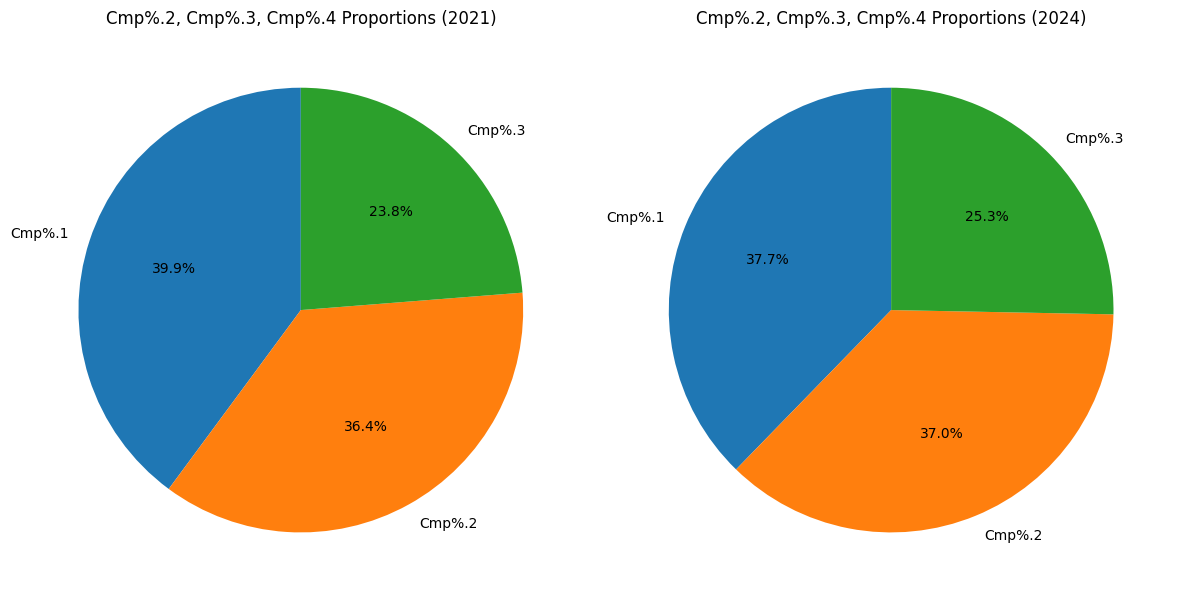

In [22]:
# Define metrics for pie charts
pie_metrics = ["Cmp%.1", "Cmp%.2", "Cmp%.3"]

# Dictionary to store aggregated values
yearly_totals = {compared_year: {metric: 0 for metric in pie_metrics}, 
                 interesting_year: {metric: 0 for metric in pie_metrics}}

# Process only the "passing" sheet
for df_name, df in filtered_data.items():
    if "passing" not in df_name.lower():  # Ensure we only process "passing" sheet
        continue  

    year = compared_year if str(compared_year) in df_name else interesting_year  # Extract year

    # Sum values for each metric
    for metric in pie_metrics:
        if metric in df.columns:
            yearly_totals[year][metric] += df[metric].sum()

# Convert dictionary to DataFrame
pie_data = pd.DataFrame(yearly_totals)

# Define color scheme
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

# Create subplots for 2018 and 2024
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for 2018
axes[0].pie(
    pie_data[compared_year], labels=pie_metrics, autopct="%1.1f%%", colors=colors, startangle=90
)
axes[0].set_title(f"Cmp%.2, Cmp%.3, Cmp%.4 Proportions ({compared_year})")

# Plot pie chart for 2024
axes[1].pie(
    pie_data[interesting_year], labels=pie_metrics, autopct="%1.1f%%", colors=colors, startangle=90
)
axes[1].set_title(f"Cmp%.2, Cmp%.3, Cmp%.4 Proportions ({interesting_year})")

# Display charts
plt.tight_layout()
plt.show()



🚨 Outliers Detected:
📌 Sheet: score_2021 | Player: Unknown | Metric: Attendance | Outlier Value: 42575.0
📌 Sheet: passing_2021 | Player: Carlos Coronel | Metric: Cmp% | Outlier Value: 54.9
📌 Sheet: passing_2021 | Player: Patryk Klimala | Metric: Cmp% | Outlier Value: 55.6
📌 Sheet: playing_time_2021 | Player: Andrew Gutman | Metric: Mn/Sub | Outlier Value: 54.0
📌 Sheet: playing_time_2021 | Player: Brian White | Metric: xG+/-90 | Outlier Value: -1.2
📌 Sheet: playing_time_2021 | Player: Florian Valot | Metric: xG+/-90 | Outlier Value: -2.56
📌 Sheet: playing_time_2021 | Player: Cameron Harper | Metric: xG+/-90 | Outlier Value: -0.48
📌 Sheet: score_2024 | Player: Unknown | Metric: Attendance | Outlier Value: 43428
📌 Sheet: score_2024 | Player: Unknown | Metric: Poss | Outlier Value: 70
📌 Sheet: playing_time_2024 | Player: Lewis Morgan | Metric: Mn/Sub | Outlier Value: 43.0
📌 Sheet: playing_time_2024 | Player: Felipe Carballo | Metric: xG+/-90 | Outlier Value: -0.88
📌 Sheet: playing_time_20

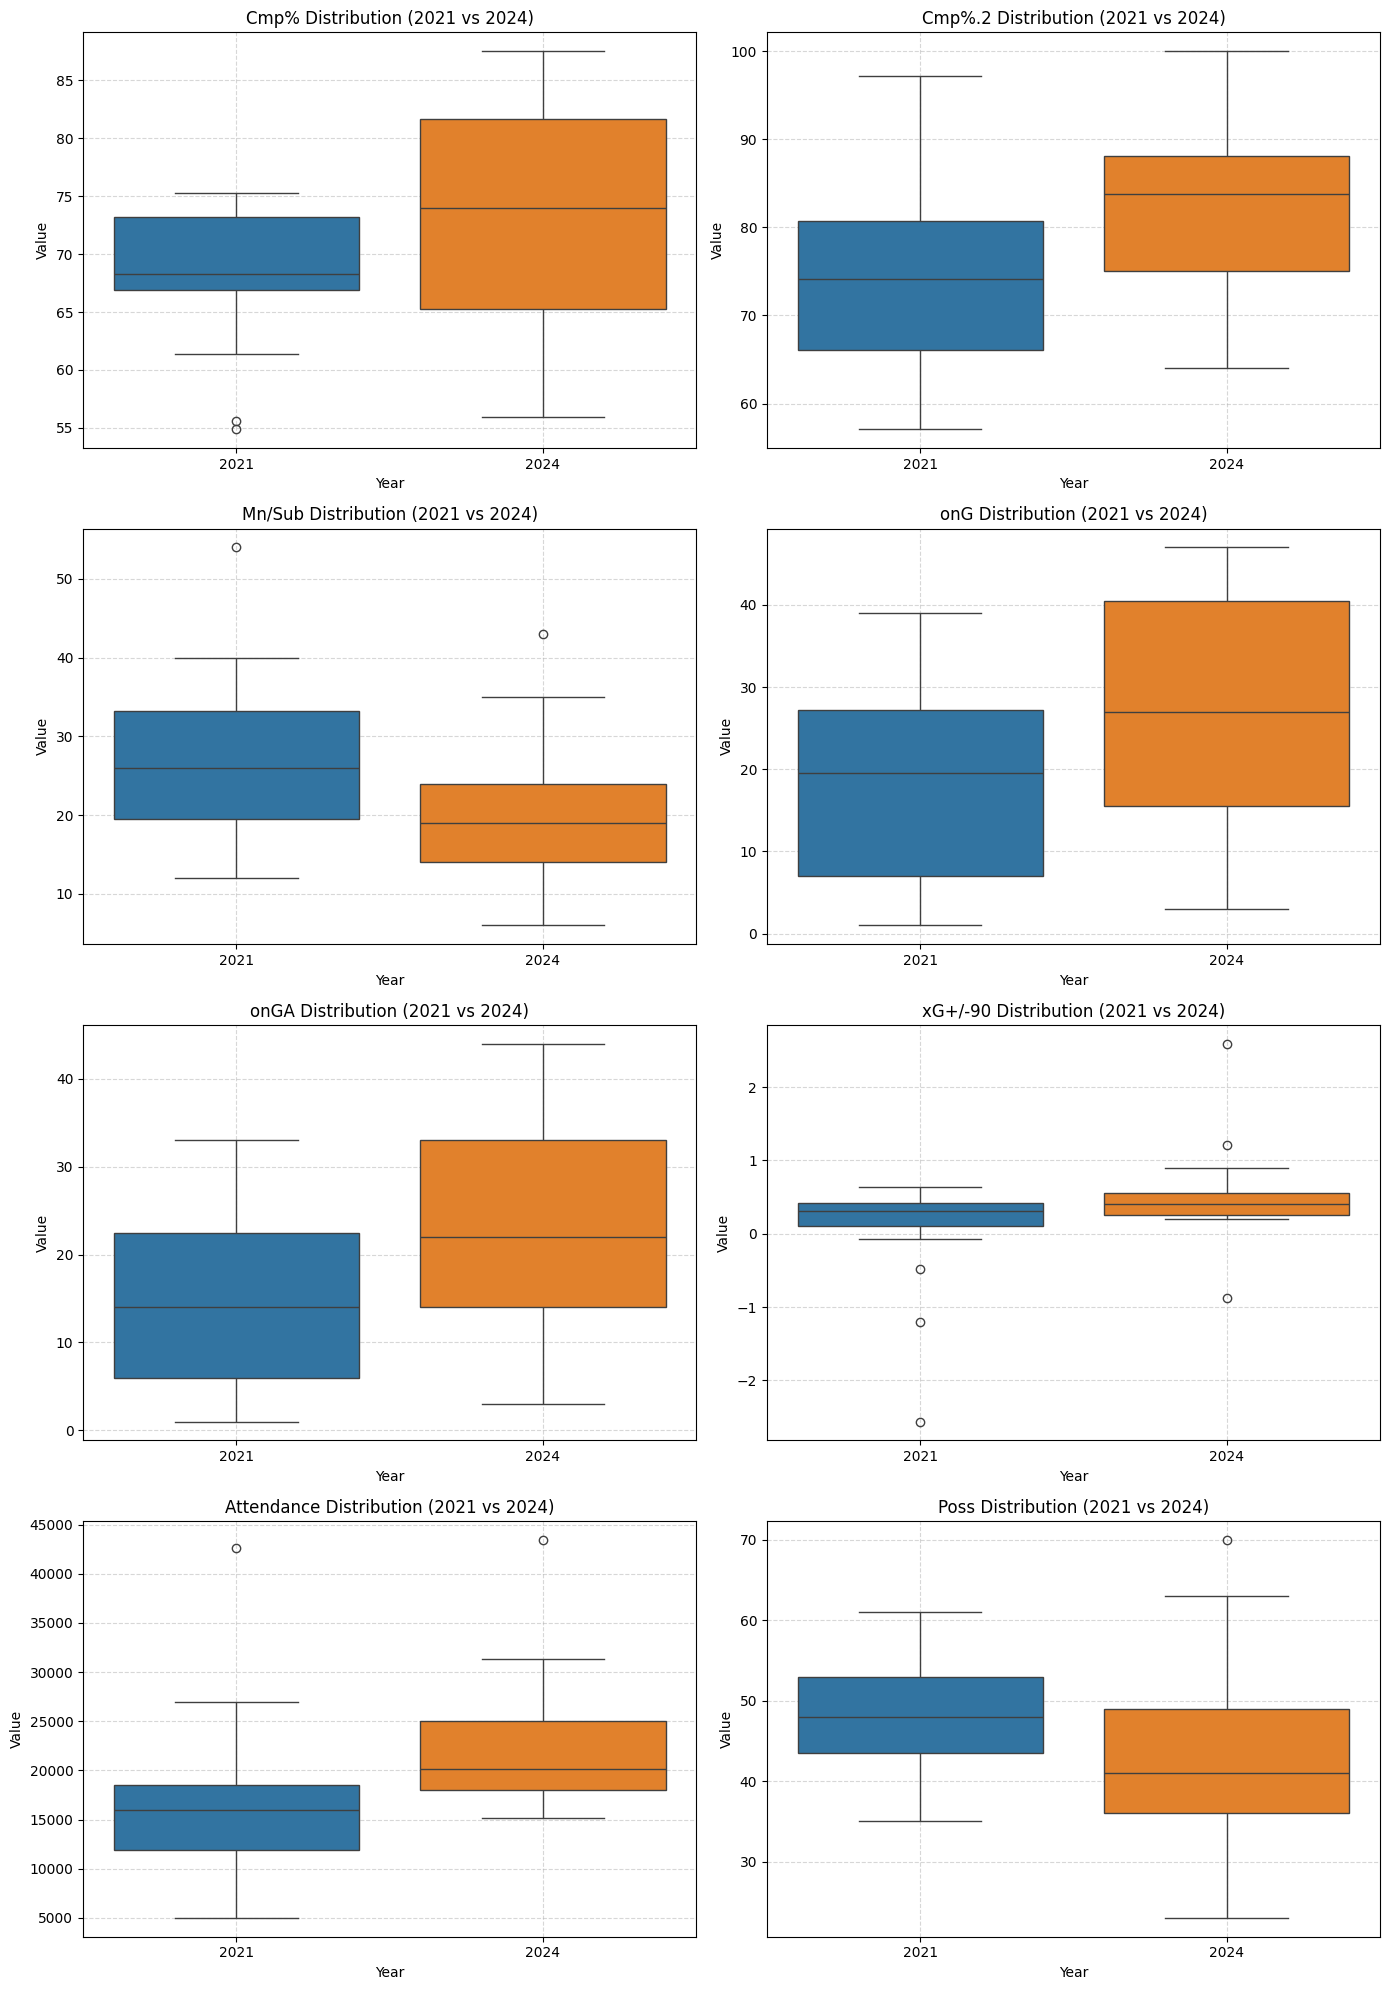

In [23]:
# Load filtered data
boxplot_data = []
outlier_instances = []

# Process each dataset
for df_name, df in filtered_data_part1.items():
    year = compared_year if str(compared_year) in df_name else interesting_year  # Extract year

    # Filter only relevant metrics
    for metric in significant_all_metric:
        if metric in df.columns:
            metric_values = df[metric].dropna()

            # Compute Q1, Q3, and IQR for outlier detection
            Q1 = metric_values.quantile(0.25)
            Q3 = metric_values.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

            # Store all data for boxplot
            for index, value in metric_values.items():
                player = df.loc[index, "Player"] if "Player" in df.columns else "Unknown"
                boxplot_data.append({"Metric": metric, "Player": player, "Year": year, "Value": value})

                # Detect outliers
                if value < lower_bound or value > upper_bound:
                    outlier_instances.append({"Sheet": df_name, "Player": player, "Metric": metric, "Outlier Value": value})

# Print outliers
if outlier_instances:
    print("\n🚨 Outliers Detected:")
    for outlier in outlier_instances:
        print(f"📌 Sheet: {outlier['Sheet']} | Player: {outlier['Player']} | "
              f"Metric: {outlier['Metric']} | Outlier Value: {outlier['Outlier Value']}")
else:
    print("\n✅ No outliers detected.")

# Convert to DataFrame for visualization
boxplot_df = pd.DataFrame(boxplot_data)

# Dynamically determine subplot grid size
num_metrics = len(significant_all_metric)
num_cols = 2  # Fixed columns for better readability
num_rows = int(np.ceil(num_metrics / num_cols))

# Set up subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 5 * num_rows))
axes = axes.flatten()  # Convert to 1D array for easier iteration

custom_palette = {compared_year: "#1f77b4", interesting_year: "#ff7f0e"}  # Blue & Orange

# Create a boxplot for each metric
for i, metric in enumerate(significant_all_metric):
    if metric in boxplot_df["Metric"].unique():
        sns.boxplot(
            x="Year", y="Value", hue="Year", data=boxplot_df[boxplot_df["Metric"] == metric],
            ax=axes[i], palette=custom_palette, legend=False  # Fix for Seaborn 0.14+ 
        )
        axes[i].set_title(f"{metric} Distribution ({compared_year} vs {interesting_year})")
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel("Value")
        axes[i].grid(True, linestyle="--", alpha=0.5)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


## 🎯 **Role-Specific Impact Analysis**  

Compare 2021 and 2024 metrics across player roles using statistical testing.
- H0: There is no significant difference in a given metric for a player's role (Attacker, Defender, or Midfielder) between 2021 and 2024
- H1: A significant difference exists in a given metric for at least one player role between 2021 and 2024

&nbsp;

Note
- Goalkeepers were excluded from the statistical analysis due to having only two samples per year. Statistical tests require a minimum of 3–5 samples for meaningful results.
- The scoring sheet was also excluded from Part 2, as it contained game-level data rather than player-specific data. Since it could not be segmented by position, it was not suitable for role-based analysis.

&nbsp;
     

##### Filter out appropriate sheets from data

In [24]:
from itertools import islice

# filter data for Part 2 analysis
filtered_data_part2 = filter_sheets_by_name(filtered_data, ['goalkeeping', 'advanced_goalkeeping', 'score'])

# Ensure that all data is there
head = dict(islice(filtered_data_part2.items(), 3))
print(head)

⏩ Skipping sheet: score_2021
⏩ Skipping sheet: goalkeeping_2021
⏩ Skipping sheet: advanced_goalkeeping_2021
⏩ Skipping sheet: score_2024
⏩ Skipping sheet: goalkeeping_2024
⏩ Skipping sheet: advanced_goalkeeping_2024
{'standard_stats_2021':                    Player   Nation    Pos  Age  MP  Starts     Min   90s  Gls  \
0          Carlos Coronel   py PAR     GK   24  34      34  3060.0  34.0  0.0   
1              Sean Davis   us USA     MF   27  34      34  3060.0  34.0  0.0   
2             Sean Nealis   us USA     DF   24  28      28  2430.0  27.0  1.0   
3             Kyle Duncan   us USA  DF,MF   23  32      27  2600.0  28.9  1.0   
4          Patryk Klimala   pl POL     FW   22  29      26  2079.0  23.1  8.0   
5                   Fábio   br BRA     FW   23  30      25  2188.0  24.3  7.0   
6             Tom Edwards  eng ENG     DF   22  27      25  1950.0  21.7  0.0   
7   Cristian Cásseres Jr.   ve VEN  MF,FW   21  27      24  2060.0  22.9  6.0   
8             John Tolkin   us 

In [25]:
# Dictionary mapping general player roles to their respective position abbreviations
role_mappings = {
            "Attacker": ["FW", "AM", "LW", "RW"],
            "Midfielder": ["MF", "DM", "CM", "LM", "RM", "WM"],
            "Defender": ["DF", "FB", "LB", "RB", "CB"],
 }

# Perform statistical analysis for each role
result_df = perform_statistical_analysis(filtered_data_part2, "RBNY_yearly_stats/significance/role_base_sig_diff.csv", is_role_based=True)

✅ Attacker in standard_stats: 3 significant metrics
✅ Midfielder in shooting: 1 significant metrics
✅ Midfielder in passing: 2 significant metrics


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Library/Frameworks/Python.framework/Versions

✅ Defender in shot_creation: 2 significant metrics
✅ Attacker in playing_time: 1 significant metrics
✅ Defender in playing_time: 3 significant metrics

📊 Results saved to RBNY_yearly_stats/significance/role_base_sig_diff.csv


In [26]:
# Load significant metrics from a CSV file and return a list of metrics."""
df_significant = pd.read_csv("RBNY_yearly_stats/significance/role_base_sig_diff.csv")

# Convert to dictionary: {Role: Metric}
role_metric_dict = df_significant.groupby('Role')['Metric'].apply(list).to_dict()

#  Print the dictionary
print(role_metric_dict)

# Flatten unique metrics across all roles to know how many unique metrics 
all_significant_metrics = set(metric for metrics in role_metric_dict.values() for metric in metrics)
print(all_significant_metrics)

{'Attacker': ['xG+/-90', 'G+A-PK', 'G+A.1', 'Gls.1'], 'Defender': ['Mn/Sub', 'onG', 'onGA', 'GCA90', 'PassLive.1'], 'Midfielder': ['Cmp%', 'Cmp%.2', 'SoT%']}
{'xG+/-90', 'onG', 'onGA', 'G+A.1', 'Cmp%', 'Gls.1', 'Mn/Sub', 'GCA90', 'PassLive.1', 'Cmp%.2', 'SoT%', 'G+A-PK'}


In [27]:
metric_stats_df = sig_metric_averages(filtered_data_part2, all_significant_metrics)

# Display or save results
print(metric_stats_df)

        Metric                Sheet       Mean  Standard Deviation
0        G+A.1  standard_stats_2021   0.171250            0.188687
1        G+A.1  standard_stats_2024   0.322174            0.404036
2        Gls.1  standard_stats_2021   0.093750            0.119266
3        Gls.1  standard_stats_2024   0.211739            0.298079
4       G+A-PK  standard_stats_2021   0.165833            0.177051
5       G+A-PK  standard_stats_2024   0.302609            0.385855
6         SoT%        shooting_2021  27.554545           13.831666
7         SoT%        shooting_2024  39.966667           23.409706
8         Cmp%         passing_2021  68.287500            5.662409
9         Cmp%         passing_2024  73.578261            9.441637
10      Cmp%.2         passing_2021  74.108333            9.388796
11      Cmp%.2         passing_2024  81.865217           10.219394
12       GCA90   shot_creation_2021   0.155833            0.154917
13       GCA90   shot_creation_2024   0.280435            0.35

In [28]:
# Assuming role_metric_dict is your dictionary
for key, value in filtered_data_part2.items():
    print(f"Key: {key}, Value: {value}")

Key: standard_stats_2021, Value:                    Player   Nation    Pos  Age  MP  Starts     Min   90s  Gls  \
0          Carlos Coronel   py PAR     GK   24  34      34  3060.0  34.0  0.0   
1              Sean Davis   us USA     MF   27  34      34  3060.0  34.0  0.0   
2             Sean Nealis   us USA     DF   24  28      28  2430.0  27.0  1.0   
3             Kyle Duncan   us USA  DF,MF   23  32      27  2600.0  28.9  1.0   
4          Patryk Klimala   pl POL     FW   22  29      26  2079.0  23.1  8.0   
5                   Fábio   br BRA     FW   23  30      25  2188.0  24.3  7.0   
6             Tom Edwards  eng ENG     DF   22  27      25  1950.0  21.7  0.0   
7   Cristian Cásseres Jr.   ve VEN  MF,FW   21  27      24  2060.0  22.9  6.0   
8             John Tolkin   us USA  DF,MF   18  28      22  1989.0  22.1  1.0   
9           Andrew Gutman   us USA  DF,MF   24  22      19  1835.0  20.4  2.0   
10           Dru Yearwood  eng ENG     MF   20  29      18  1689.0  18.8  1.

📌 Year: 2021 | Player: Brian White | Role: Attacker | Metric: xG+/-90 | Outlier Value: -1.2
📌 Year: 2021 | Player: Cameron Harper | Role: Attacker | Metric: xG+/-90 | Outlier Value: -0.48
📌 Year: 2024 | Player: Julian Hall | Role: Attacker | Metric: xG+/-90 | Outlier Value: 2.59
📌 Year: 2024 | Player: Julian Hall | Role: Attacker | Metric: G+A.1 | Outlier Value: 1.69
📌 Year: 2024 | Player: Cameron Harper | Role: Midfielder | Metric: Cmp% | Outlier Value: 58.8
📌 Year: 2024 | Player: Julian Hall | Role: Attacker | Metric: Gls.1 | Outlier Value: 1.13
📌 Year: 2024 | Player: Sean Nealis | Role: Defender | Metric: Mn/Sub | Outlier Value: 27.0
📌 Year: 2024 | Player: Andrés Reyes | Role: Defender | Metric: Mn/Sub | Outlier Value: 6.0
📌 Year: 2021 | Player: Sean Nealis | Role: Defender | Metric: PassLive.1 | Outlier Value: 1.0
📌 Year: 2024 | Player: Cameron Harper | Role: Midfielder | Metric: Cmp%.2 | Outlier Value: 65.1
📌 Year: 2024 | Player: Ronald Donkor | Role: Midfielder | Metric: SoT% | O

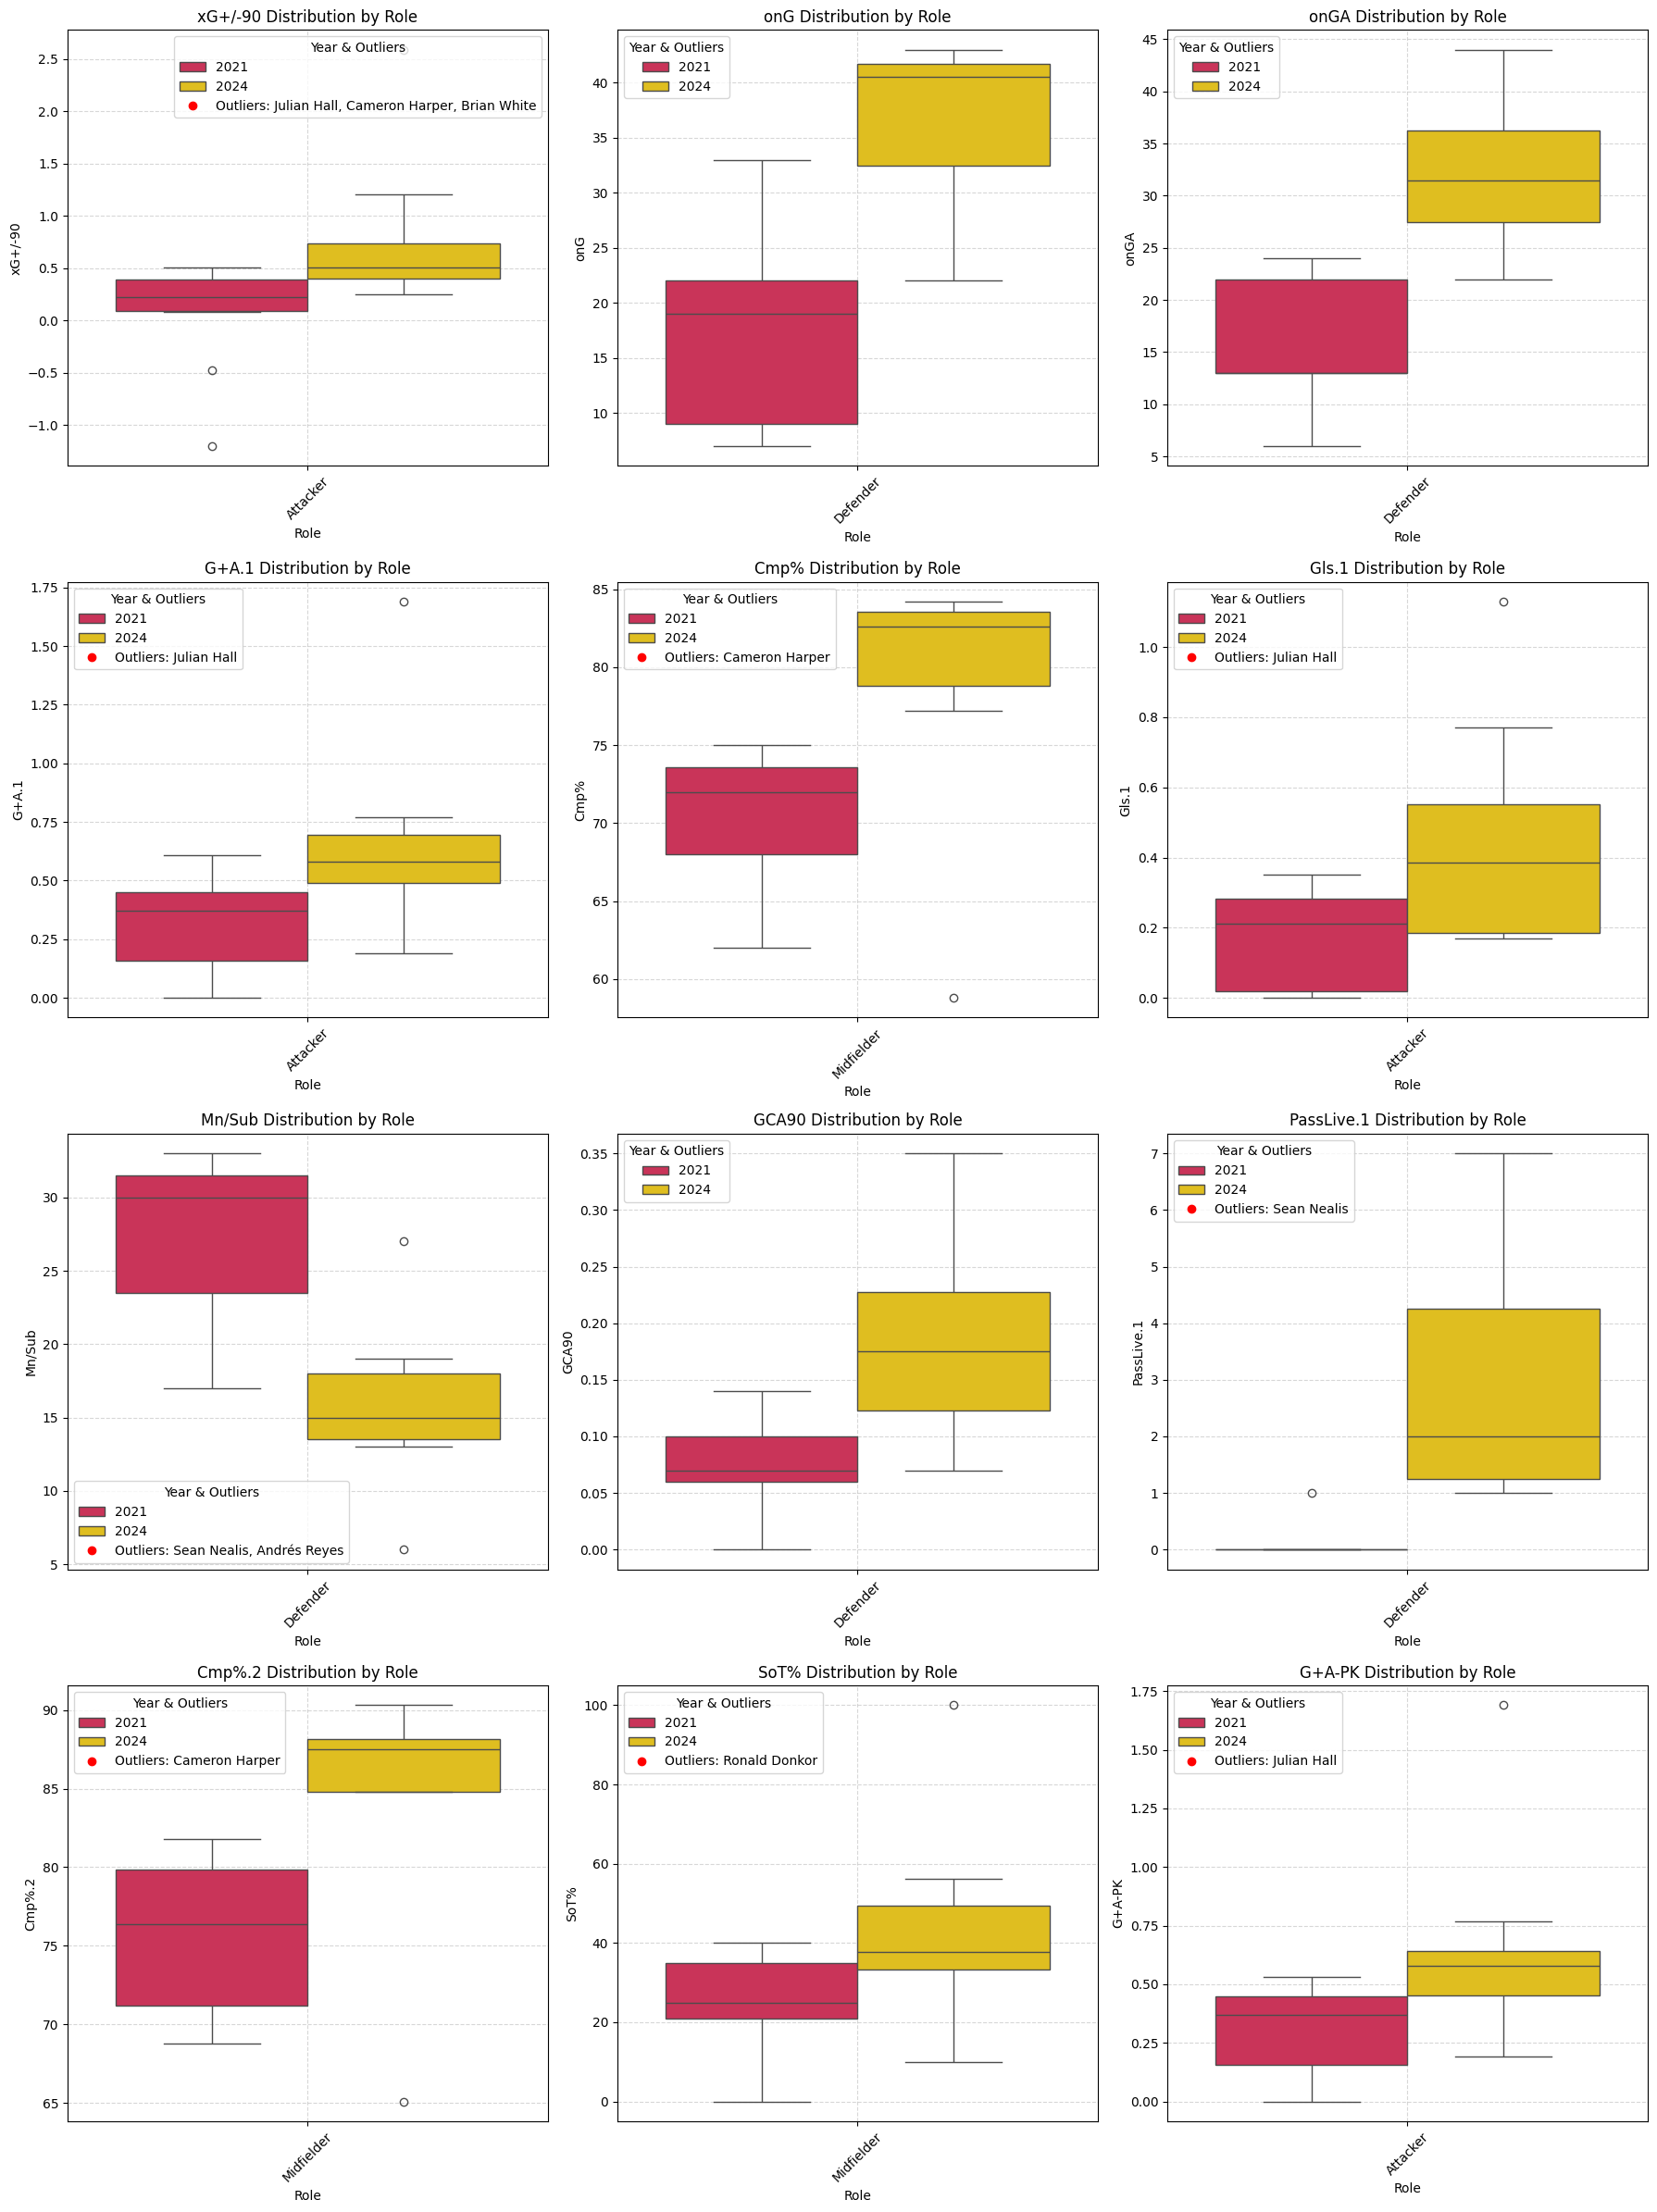

In [31]:
# Function to detect outliers using IQR method within each Role-Year group
def detect_outliers(df, column):
    outliers_list = []
    
    for (role, year), group in df.groupby(["Role", "Year"]):  # Detect outliers per Role-Year
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = group[(group[column] < lower_bound) | (group[column] > upper_bound)]
        
        if not outliers.empty:
            for _, row in outliers.iterrows():
                outliers_list.append((row["Player"], row["Role"], row["Year"], row["Metric"], row["Value"]))
    
    return outliers_list

# Step 1: Prepare long-format data
long_data = []

for key, df in filtered_data_part2.items():
    year = int(key.split("_")[-1])  
    df["Year"] = year  
    df["Role"] = df["Pos"].apply(lambda x: next((role for role, positions in role_mappings.items() 
                                                 if any(pos in str(x).split(",") for pos in positions)), "Other"))
    melted_df = df.melt(id_vars=["Player", "Pos", "Role", "Year"], var_name="Metric", value_name="Value")
    long_data.append(melted_df)

boxplot_df = pd.concat(long_data, ignore_index=True)

# Step 2: Define colors
custom_palette = {2021: "#e21b4d", 2024: "#ffd300"}

# Step 3: Create plots
num_cols = 3  
num_rows = -(-len(all_significant_metrics) // num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6))
axes = axes.flatten()

for i, metric in enumerate(all_significant_metrics):
    roles_for_metric = [role for role, metrics in role_metric_dict.items() if metric in metrics]
    metric_df = boxplot_df[(boxplot_df["Metric"] == metric) & (boxplot_df["Role"].isin(roles_for_metric))]

    if metric_df.empty:
        print(f"Skipping {metric} (no data)")
        continue

    # Detect outliers within each Role-Year group
    outliers_list = detect_outliers(metric_df, "Value")
    outlier_players = [player for player, role, year, met, val in outliers_list if met == metric]  # Filter correct metric

    # Print only relevant outliers
    for player, role, year, met, val in outliers_list:
        if met == metric:
            print(f"📌 Year: {year} | Player: {player} | Role: {role} | Metric: {metric} | Outlier Value: {val}")

    # Create the boxplot
    sns.boxplot(x="Role", y="Value", hue="Year", data=metric_df, palette=custom_palette, ax=axes[i])
    
    axes[i].set_title(f"{metric} Distribution by Role")
    axes[i].set_xlabel("Role")
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True, linestyle="--", alpha=0.5)

    # Add outlier names to legend only if there are any
    handles, labels = axes[i].get_legend_handles_labels()
    if outlier_players:
        handles.append(plt.Line2D([0], [0], color="red", linestyle="", marker="o"))  # Dummy handle
        labels.append(f"Outliers: {', '.join(set(outlier_players))}")  # Ensure unique names
    
    axes[i].legend(handles=handles, labels=labels, title="Year & Outliers")

# Step 4: Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [38]:
# Calculates the percentage increase of a given metric between two years.
def calculate_percentage_increase(df, column, start_year, end_year):
    start_value = df[df["Year"] == start_year][column].mean()
    end_value = df[df["Year"] == end_year][column].mean()
    
    if start_value == 0 or pd.isna(start_value) or pd.isna(end_value):
        return None  # Avoid division by zero or missing values

    percentage_increase = ((end_value - start_value) / start_value) * 100
    return round(percentage_increase, 2)

# Example usage:
pass_completion_increase = calculate_percentage_increase(filtered_data_part2, "Cmp%", 2010, 2024)
goals_increase = calculate_percentage_increase(filtered_data_part2, "Gls.1", 2010, 2024)

print(f"Pass Completion Increase: {pass_completion_increase}%")
print(f"Goals Increase: {goals_increase}%")


KeyError: 'Year'

When it comes to attackers, one person gets noticed to be a high scorer and it is Julian Hall. this player only played 190 minutes and was able to score 2 goals. This is why he appears to be such an overperformer compared to others when it comes to metrics that gets divided by amount played (Goals/90 mins, G+A-PK, and G+A). It would be interesting to see in 2025 how well he performs when having more play time. 

In 2024, one player that is not shining compared to its fellow midfielders in terms of passing metrics is Cameron Harper. He is an underperformer in total completed pass %. More specifically, he is suffering when it comes to medium length completed passes. It looks like he has an acceptable amounts of attempts. This might be explained from the fact that he can also be considered a defender and not just midfielder.

Ronald Donkor appears to outperform when it comes to its accuracy in shooting on target (SoT%). However, the accuracy is so high because he only had 1 attempt that he succeeded at.

When it comes to min per substitution, we have two outliers. Sean nealis was shown to have 27 minutes per substituion while Andres Reyes only had 6 minutes per substitution.

In [30]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Create a Dash app
app = dash.Dash(__name__)

# Sample data
df = px.data.gapminder().query("year == 2007")

# Create a graph
fig = px.scatter(df, x="gdpPercap", y="lifeExp", size="pop", color="continent",
                 hover_name="country", log_x=True)

# Layout (Frontend)
app.layout = html.Div([
    html.H1("GDP vs Life Expectancy"),
    dcc.Graph(figure=fig)  # Display graph
])

# Run app
if __name__ == "__main__":
    app.run_server(debug=True)



Do correlation between all metrics and ppg to determine which metric predicts the team performance